In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
from src.cort_processor import *

from src.plotter import *
from src.filters import *
import math
import pickle
import scipy
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from matplotlib.pyplot import cm
from scipy import signal
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from matplotlib import colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import tdt 
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, iirnotch, filtfilt, resample, hilbert, welch
from scipy.fftpack import fft,fftfreq,rfft,irfft,ifft
from scipy.io import savemat
from src.phase_decoder_support import *
from src.neural_analysis import *
from src.wiener_filter import *
from src.folder_handler import *
from src.tdt_support import *
from src.decoders import *
import random
import pandas as pd

In [2]:
rollie1129 = CortProcessor('/mnt/c/oobootoo/rat-fes/data/meepo-injured-files/1010')
rollie1129.process(clear_storage = False)

read from t=0s to t=334.57s
read from t=0s to t=212.6s
read from t=0s to t=210.65s
read from t=0s to t=191.82s


(array([[100.,  80.,  80., ...,  60.,  80.,  20.],
        [160.,  60., 120., ...,  40.,  80.,  60.],
        [ 80.,  40.,  40., ...,  20.,  20.,  60.],
        ...,
        [ 60.,  40.,  40., ...,  20.,   0.,  60.],
        [ 80.,  80.,  40., ...,  40.,  40.,  60.],
        [ 20.,  20.,  40., ...,   0., 100.,   0.]]),
 array([[143.0400436 ,  54.0921713 , 104.95395216, ...,  93.80215493,
          82.74474859, 128.0191513 ],
        [148.70896817,  68.7751947 , 126.888956  , ..., 102.58270101,
          87.69990038, 142.75022041],
        [149.1923775 ,  63.02866892, 120.79020691, ...,  85.70969186,
          88.71986213, 153.31594076],
        ...,
        [ 95.81947169,  86.1716278 , 108.93070882, ...,  57.40052289,
          96.55728965, 139.63058468],
        [109.83075873,  79.50716988, 104.95041505, ...,  60.49975602,
          92.38215368, 142.51177422],
        [ 99.20815723,  65.39235735,  88.41289005, ...,  64.46647048,
          94.29945136, 157.37381636]]))

In [3]:
#############EVERYTHING HERE HAS ACCESS TO SEL

# def relative_x(self, 'mark_name'):
def relative_x_tmp(bodypart):
    if bodypart == 'shoulder':
        print('invalid selection')
        return None
    bp_num = rollie1129.data['bodyparts'].index(bodypart)
    sh_num = rollie1129.data['bodyparts'].index('shoulder')
    bodypart_x = rollie1129.kin_data[0]['coords'][:, bp_num, 0]
    shoulder_x = rollie1129.kin_data[0]['coords'][:, sh_num, 0]
    relative_x = shoulder_x - bodypart_x
    min_x = np.min(relative_x)
    rel_x = relative_x - min_x
    return rel_x


########EVERYTHING BELOW THIS POINT IS IN A SEPARATE IPYNB

def replace_with_null(arr, buffer):
    i = 0
    while i < len(arr):
        if arr[i] == 0:
            j = i
            while j < len(arr) and arr[j] == 0:
                j += 1
            if j - i >= buffer:
                for k in range(i, j):
                    arr[k] = None
            i = j
        else:
            i += 1
    return arr

def replace_null(arr):
    for i in range(arr.shape[0]):
        if np.isnan(arr[i]) == True:
            arr[i] = 0
    return arr

def x_swing_binary(kin_signal):
    dt = 1/200
    dk = np.diff(kin_signal)
    dkdt_tmp = dk/dt
    dddk = np.diff(kin_signal, 3)
    dddkdddt_tmp = dddk/(dt**3)
    dddkdddt = lowpass_filt(dddkdddt_tmp, 10, 200)
    dkdt = lowpass_filt(dkdt_tmp, 10, 200)
    dkdt = np.append(dkdt, [0])
    dddkdddt = np.append(dddkdddt, [0,0,0])
    probable_kink = np.int64(len(kin_signal)*0.025)
    kin_peaks, _ = spicy.signal.find_peaks(kin_signal, wlen= 600, prominence = 3, distance = 50, height = 0.4*np.sort(kin_signal)[-probable_kink])
    dddkdddt_valleys, _ = spicy.signal.find_peaks(-(dddkdddt), distance= 50, threshold =10,prominence = 5, height = -0.5*np.sort(dddkdddt)[probable_kink])    
    print('dddkdddt_valleys:', len(dddkdddt_valleys))
    bdkdt = np.zeros((dkdt.shape[0]))
    threshold = np.sort(dkdt)[-probable_kink]
    print("swing threshold:", threshold*0.1)

    for i in range(len(dkdt)):
        if (dkdt[i]) >= threshold*0.1:
            bdkdt[i] = 1
    for i in range(1,len(bdkdt)-1,1):
        if (bdkdt[i]) == 1:
            if (bdkdt[i+1] == 0) and (bdkdt[i-1] == 0):
                bdkdt[i] = 0
    for i in range(1,len(bdkdt)-1,1):
        if (bdkdt[i]) == 0:
            if (bdkdt[i+1] == 1) and (bdkdt[i-1] == 1):
                bdkdt[i] = 1
    for i in range(0,len(bdkdt)-50,1):
        if (bdkdt[i] == 1) and (bdkdt[i-1] == 0):
            index_list = []
            index_list.append(i)
            tick = 0
            while bdkdt[i+1+tick] == 1:
                index_list.append(i+1+tick)
                tick = tick+1
            if any(val in kin_peaks for val in index_list) or any(val in dddkdddt_valleys for val in index_list):
                if any(val in kin_peaks for val in index_list) and any(val in dddkdddt_valleys for val in index_list):
                    continue
                else:
                    for index in index_list:
                        bdkdt[index] = 0.5
            else:
                for index in index_list:
                    bdkdt[index] = 0  
    return bdkdt

    
def x_stance_binary(kin_signal):
    dt = 1/200
    dk = np.diff(kin_signal)
    dkdt_tmp = dk/dt
    dkdt = lowpass_filt(dkdt_tmp, 10, 200)
    dkdt = np.append(dkdt, [0])
    ddk = np.diff(kin_signal,2)
    ddkddt_tmp = ddk/(dt**2)
    ddkddt = lowpass_filt(ddkddt_tmp, 10, 200)
    ddkddt = np.append(ddkddt, [0, 0])
    probable_kink = np.int64(len(kin_signal)*0.025)
    kin_valleys, _ = spicy.signal.find_peaks(-(kin_signal), wlen= 600, prominence = 3, distance = 50, height = -2*np.sort(kin_signal)[probable_kink])    
    ddkddt_peaks, _ = spicy.signal.find_peaks(ddkddt, prominence=3, distance= 50, height = 0.3*np.sort(ddkddt)[-probable_kink])    
    ddkddt_valleys, _ = spicy.signal.find_peaks(-(ddkddt), prominence=3, distance= 50, height = -0.3*np.sort(ddkddt)[probable_kink]) 
    ddkddt_peaks = ddkddt_peaks - 25
    ddkddt_valleys = ddkddt_valleys + 25
    qdkdt = np.zeros((dkdt.shape[0]))
    threshold = np.sort(dkdt)[probable_kink]
    print("stance threshold:", threshold*0.1)
    for i in range(len(dkdt)):
        if (dkdt[i]) <= threshold*0.1:
            qdkdt[i] = -1
    for i in range(1,len(qdkdt)-1,1):
        if (qdkdt[i]) == -1:
            if (qdkdt[i+1] == 0) and (qdkdt[i-1] == 0):
                qdkdt[i] = 0
    for i in range(1,len(qdkdt)-1,1):
        if (qdkdt[i]) == 0:
            if (qdkdt[i+1] == -1) and (qdkdt[i-1] == -1):
                qdkdt[i] = -1
    for i in range(0,len(qdkdt)-50,1):
        if (qdkdt[i] == -1) and (qdkdt[i-1] == 0):
            index_list = []
            index_list.append(i)
            tick = 0
            while qdkdt[i+1+tick] == -1:
                index_list.append(i+1+tick)
                tick = tick+1
            if any(val in ddkddt_valleys for val in index_list) or any(val in ddkddt_peaks for val in index_list):
                if any(val in ddkddt_valleys for val in index_list) and any(val in ddkddt_peaks for val in index_list):
                    continue
                else:
                    for index in index_list:
                        qdkdt[index] = -0.5
            else:
                for index in index_list:
                    qdkdt[index] = 0
    return qdkdt

def slow_stance_exceptor(kin_signal, sss):
    dt = 1/200
    dk = np.diff(kin_signal)
    dkdt_tmp = dk/dt
    dkdt = lowpass_filt(dkdt_tmp, 10, 200)
    dkdt = np.append(dkdt, [0])
    ddk = np.diff(kin_signal,2)
    ddkddt_tmp = ddk/(dt**2)
    ddkddt = lowpass_filt(ddkddt_tmp, 10, 200)
    ddkddt = np.append(ddkddt, [0, 0])
    probable_kink = np.int64(len(kin_signal)*0.025)
    kin_valleys, _ = spicy.signal.find_peaks(-(kin_signal), wlen= 600, prominence = 3, distance = 50, height = -2*np.sort(kin_signal)[probable_kink])    
    ddkddt_peaks, _ = spicy.signal.find_peaks(ddkddt, prominence=3, distance= 50, height = 0.3*np.sort(ddkddt)[-probable_kink])    
    ddkddt_valleys, _ = spicy.signal.find_peaks(-(ddkddt), prominence=3, distance= 50, height = -0.3*np.sort(ddkddt)[probable_kink]) 
    ddkddt_peaks = ddkddt_peaks - 25
    ddkddt_valleys = ddkddt_valleys + 25
    sss_null = replace_with_null(sss, 30)
    for i in range(1,len(sss)-1,1):
        if sss[i] == 0 and sss[i] != sss[i-1]:
            index_list = []
            index_list.append(i)
            tick = 0
            while sss[i+1+tick] == sss[i]:
                index_list.append(i+1+tick)
                tick = tick+1
            if sss[i-1] in (-0.5, -1) and sss[i+1+tick] in (-0.5, -1):
                for index in index_list:
                    sss[index] = -1
    for i in range(1,len(sss)-1,1):
        if sss[i] == -0.5 and sss[i] != sss[i-1]:
            index_list = []
            index_list.append(i)
            tick = 0
            while sss[i+1+tick] == sss[i]:
                index_list.append(i+1+tick)
                tick = tick+1
            if sss[i-1] in (-0.5, -1) or sss[i+1+tick] in (-0.5, -1):
                for index in index_list:
                    sss[index] = -1
    for i in range(1,len(sss)-1,1):
        if sss[i] == -1 and sss[i] != sss[i-1]:
            index_list = []
            index_list.append(i)
            tick = 0
            while sss[i+1+tick] == sss[i]:
                index_list.append(i+1+tick)
                tick = tick+1
            if any(val in ddkddt_valleys for val in index_list) and any(val in ddkddt_peaks for val in index_list):
                continue
            else:
                for index in index_list:
                    sss[index] = -0.5
    sss = replace_null(sss)
    return sss

def stance_swing_trinary(sss, kin_signal = None, slow_stance_exception = False): 
    if sss is None and kin_signal is not None:
        swing_ind = x_swing_binary(kin_signal)
        stance_ind = x_stance_binary(kin_signal)
        sss = np.sum((swing_ind, stance_ind), axis = 0) 
        if slow_stance_exception == True:
            sss = slow_stance_exceptor(kin_signal, sss)
    
    sss_null = replace_with_null(sss, 30)
    for i in range(10,len(sss_null)-50,1):
        if (sss_null[i] == 0) and (sss_null[i-1] != 0):
            index_list = []
            index_list.append(i)
            tick = 0
            while sss_null[i+1+tick] == 0:
                index_list.append(i+1+tick)
                tick = tick+1
            if sss_null[i-1] is not None and sss_null[i+1+tick] is not None:
                if sss_null[i-1] == sss_null[i+1+tick]:
                    for index in index_list:
                        sss_null[index] = sss_null[i-1]
                elif len(index_list) > 1:
                    if len(index_list) % 2 == 1:
                        mid = len(index_list)//2
                        for index in index_list[:mid]:
                            sss_null[index] = sss_null[i-1]
                        for index in index_list[mid+1:]:
                            sss_null[index] = sss_null[i+tick+1]
                    elif len(index_list) % 2 == 0:
                        mid = len(index_list)//2
                        for index in index_list[:mid]:
                            sss_null[index] = sss_null[i-1]
                        for index in index_list[mid:]:
                            sss_null[index] = sss_null[i+tick+1]
    for i in range(1,len(sss_null)-1,1):
        if (sss_null[i] == 0):
            if sss_null[i-1] is not None and sss_null[i+1] is not None:
                if (sss_null[i-1] != 0) and (sss_null[i+1] != 0):
                    if random.random() <= 0.5:
                        sss_null[i] = sss_null[i-1]
                    else:
                        sss_null[i] = sss_null[i+1]
    np.array(sss_null)
    sstrinary = replace_null(sss_null)
    return sstrinary


def scrubber(phase, length):
    adjustments = 0
    for i in range(1,len(phase)-1,1):
        if phase[i] != 0 and phase[i] != phase[i-1] and abs(phase[i]) < 1:
            index_list = []
            index_list.append(i)
            tick = 0
            while phase[i+1+tick] == phase[i]:
                index_list.append(i+1+tick)
                tick = tick+1
            if len(index_list) < length:
                if abs(phase[i-1]-phase[i]) < abs(phase[i+1+tick]-phase[i]):
                    for index in index_list:
                        phase[index] = phase[i-1]
                        adjustments = adjustments+1
                elif abs(phase[i-1]-phase[i]) > abs(phase[i+1+tick]-phase[i]):
                    for index in index_list:
                        phase[index] = phase[i+1+tick]
                        adjustments = adjustments+1              
                elif phase[i-1] == phase[i+1+tick]:
                    for index in index_list:
                        phase[index] = phase[i+1+tick]
                        adjustments = adjustments+1
                elif abs(phase[i-1]-phase[i]) == abs(phase[i+1+tick]-phase[i]):
                    if abs(phase[i-1]) > abs(phase[i+1+tick]):
                        for index in index_list:
                            phase[index] = phase[i-1]
                            adjustments = adjustments+1
                    if abs(phase[i-1]) < abs(phase[i+1+tick]):
                        for index in index_list:
                            phase[index] = phase[i+1+tick]
                            adjustments = adjustments+1
            
    print(adjustments)
    return phase


def forelimb_phaser(slow_stance_exception = False):
    rel_x1 = relative_x_tmp('wrist')
    rel_x2 = relative_x_tmp('knuckle')
    rel_x3 = relative_x_tmp('finger')
    wrist_phase = stance_swing_trinary(sss= None, kin_signal = rel_x1, slow_stance_exception = slow_stance_exception)
    knuckle_phase = stance_swing_trinary(sss= None, kin_signal = rel_x2, slow_stance_exception = slow_stance_exception)
    finger_phase = stance_swing_trinary(sss= None, kin_signal = rel_x3, slow_stance_exception = slow_stance_exception)
    sum_phase = np.sum((wrist_phase, knuckle_phase, finger_phase), axis=0)
    for i in range(1,len(sum_phase)-1,1):
        if sum_phase[i] >= 1.5 and sum_phase[i] < 3 and sum_phase[i] != sum_phase[i-1]:
            index_list = []
            index_list.append(i)
            tick = 0
            while sum_phase[i+1+tick] == sum_phase[i]:
                index_list.append(i+1+tick)
                tick = tick+1
            if sum_phase[i-1] >= 1.5 or sum_phase[i+1+tick] >= 1.5:
                for index in index_list:
                    sum_phase[index] = 3
        if sum_phase[i] <= -1.5 and sum_phase[i] > -3 and sum_phase[i] != sum_phase[i-1]:
            index_list = []
            index_list.append(i)
            tick = 0
            while sum_phase[i+1+tick] == sum_phase[i]:
                index_list.append(i+1+tick)
                tick = tick+1
            if sum_phase[i-1] <= -1.5 or sum_phase[i+1+tick] <= -1.5:
                for index in index_list:
                    sum_phase[index] = -3
    for i in range(1,len(sum_phase)-1,1):
        if sum_phase[i] >= 0.5 and sum_phase[i] < 3 and sum_phase[i] != sum_phase[i-1]:
            index_list = []
            index_list.append(i)
            tick = 0
            while sum_phase[i+1+tick] == sum_phase[i]:
                index_list.append(i+1+tick)
                tick = tick+1
            if sum_phase[i-1] >= 1.5 and sum_phase[i+1+tick] >= 1.5:
                for index in index_list:
                    sum_phase[index] = 3
        if sum_phase[i] <= -0.5 and sum_phase[i] > -3 and sum_phase[i] != sum_phase[i-1]:
            index_list = []
            index_list.append(i)
            tick = 0
            while sum_phase[i+1+tick] == sum_phase[i]:
                index_list.append(i+1+tick)
                tick = tick+1
            if sum_phase[i-1] <= -1.5 and sum_phase[i+1+tick] <= -1.5:
                for index in index_list:
                    sum_phase[index] = -3
    for i in range(len(sum_phase)):
        if sum_phase[i] < 1.5 and sum_phase[i] > -1.5:
            sum_phase[i] = 0
    sum_phase = sum_phase /3
    sum_phase = stance_swing_trinary(sss = sum_phase)
    sum_phase = scrubber(sum_phase, 10)
    for i in range(1,len(sum_phase)-1,1):
        if abs(sum_phase[i]) < 1 and sum_phase[i] != 0 and sum_phase[i] != sum_phase[i-1]:
            index_list = []
            index_list.append(i)
            tick = 0
            while sum_phase[i+1+tick] == sum_phase[i]:
                index_list.append(i+1+tick)
                tick = tick+1
            if sum_phase[i-1] == 0 or sum_phase[i+tick+1] == 0:
                for index in index_list:
                    sum_phase[index] = 0
            elif sum_phase[i] > 0:
                if sum_phase[i-1] < 0 and sum_phase[i+tick+1] < 0:
                    for index in index_list:
                        sum_phase[index] = 1
            elif sum_phase[i] < 0:
                if sum_phase[i-1] > 0 and sum_phase[i+tick+1] > 0:
                    for index in index_list:
                        sum_phase[index] = -1
    sum_phase = scrubber(sum_phase, 500)
    return sum_phase

In [4]:
fore_phase_test = forelimb_phaser(slow_stance_exception = True)

dddkdddt_valleys: 405
swing threshold: 16.101956738382412
stance threshold: -13.389219928745618
dddkdddt_valleys: 403
swing threshold: 18.617557866143144
stance threshold: -14.613011131613753
dddkdddt_valleys: 401
swing threshold: 20.053638637112403
stance threshold: -15.181810879722192
13
486


In [5]:
df = pd.read_csv('/mnt/c/oobootoo/rat-fes/data/meepo-injured-files/accuracy_testing.csv')

In [6]:
fnum = rollie1129.kin_data[0]['fnum']
stance_index = df['stance']
swing_index = df['swing']

In [7]:
wrist_x = rollie1129.kin_data[0]['coords'][:, 9, 0]
knuckle_x = rollie1129.kin_data[0]['coords'][:, 8, 0]
finger_x = rollie1129.kin_data[0]['coords'][:, 7, 0]
shoulder_x = rollie1129.kin_data[0]['coords'][:, 11, 0]
relative_x = shoulder_x - wrist_x
min_x = np.min(relative_x)
rel_x = relative_x - min_x
relative_x2 = shoulder_x - knuckle_x
min_x2 = np.min(relative_x2)
rel_x2 = relative_x2 - min_x2
relative_x3 = shoulder_x - finger_x
min_x3 = np.min(relative_x3)
rel_x3 = relative_x3 - min_x3
fore_angle = rollie1129.kin_data[0]['angles'][:, 6]
stance_test = x_stance_binary(rel_x)
swing_test = x_swing_binary(rel_x)
sss = np.sum((swing_test, stance_test), axis = 0) 
sss = slow_stance_exceptor(rel_x, sss)

stance threshold: -13.389219928745618
dddkdddt_valleys: 405
swing threshold: 16.101956738382412


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
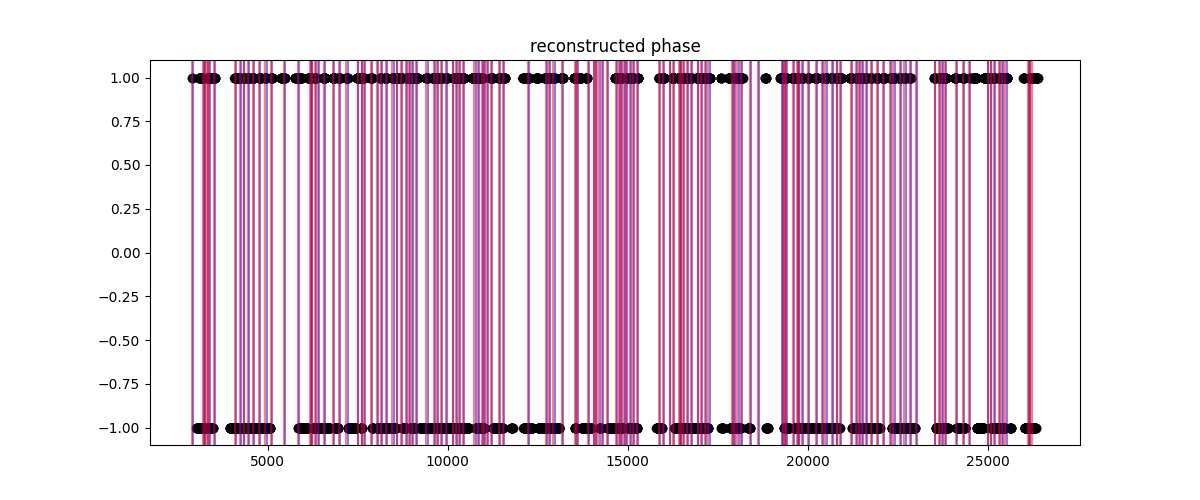

In [20]:
figq, (ax4) = plt.subplots(1, 1, figsize=(12,5),sharex = True)
fore_test_test = fore_phase_test[500:24000]
fore_test_test = replace_with_null(fore_test_test, 1)
ax4.scatter(fnum[500:24000], fore_test_test, c = 'k', alpha = 0.25)
# ax4.scatter(fnum, swing_test, c = 'r', alpha = 0.5)
# ax4.scatter(fnum, stance_test, c = 'b', alpha = 0.5)
# ax4.scatter(fnum, sss, c = 'purple', alpha = 0.5)


ax4.tick_params(axis='y', colors='black')
ax4.set_title("reconstructed phase")

for i in range(len(stance_index)):
    ax4.axvline(x = stance_index[i] , c = 'b', alpha = 0.5)
for i in range(len(swing_index)):
    ax4.axvline(x = swing_index[i] , c = 'r', alpha = 0.5)